In [4]:
### Defining Environment variables pointing to user folders
from os import environ
from glob import glob

environ['DATA_STORAGE'] = "/workarea/local/private/cache/data"
environ['MODEL_STORAGE'] = "/workarea/local/shared/scapelli/"

environ['INPUT_PATH'] = environ['DATA_STORAGE']+"/j100/*.root"
environ['INPUT_FILES'] = " ".join(glob(environ['INPUT_PATH']))

environ['ACCEPTANCE_PREPROCESSING'] = environ['MODEL_STORAGE']+"/models/acceptance/tX.pkl"
environ['EFFICIENCY_PREPROCESSING'] = environ['MODEL_STORAGE']+"/models/efficiency/tX.pkl"

environ['NB_EXPORT'] = "True"

# Preprocessing steps for *Acceptance* and *Efficiency* models
##### Tested on environment `LHCb Analysis Facility` of Docker image [`landerlini/lhcbaf:v0p8`](https://hub.docker.com/r/landerlini/lhcbaf)

This is the first notebook of the processing chain. Here, we obtain the data from the remote storage and convert them from ROOT format to pandas DataFrames. Then we apply a `QuantileTransformer` from `scikit-learn` to present to the Artificial Neural Networks Gaussian distributed data. Finally we store to remote storage the preprocessing steps.

This is the notebook where the input features and the labels are defined.

### Technologies and libraries
On top of the standard Python echosystem we are using:
 * `uproot` to convert data from `ROOT TTrees` to `pandas DataFrames`
 * `dask DataFrame` to enable processing datasets larger than the available RAM. Dask takes care of flushing from disk to RAM the data, converting from ROOT to pandas data format on demand.
 * `Arrow Feather` data format to cache in local storage the training dataset
     * Note that custom wrappers to Dask and TensorFlow, as defined in `feather_io.py` are needed 

In [2]:
import numpy as np
import pandas as pd
!conda run -n tf_on_gpu python3 -m pip install -q "dask[diagnostics]"
import dask.dataframe as ddf
import uproot
from os import environ

/usr/local/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading data
Input data are obtained from the environment variable `$INPUT_FILES`.
For debugging purpose a default value is provided.

In [3]:
from glob import glob
file_pattern = "/workarea/cloud-storage/anderlinil/LamarrBenderTrain/j100/*.root" # default path
default_file_path = environ.get("INPUT_PATH", file_pattern)
file_list = environ.get("INPUT_FILES", " ".join(glob(default_file_path))).split(" ")

print (f"Found {len(file_list)} files from {default_file_path}")  

Found 10 files from /workarea/local/private/cache/data/j100/*.root


In [4]:
file_list

['/workarea/local/private/cache/data/j100/tuple-4.root',
 '/workarea/local/private/cache/data/j100/tuple-5.root',
 '/workarea/local/private/cache/data/j100/tuple-8.root',
 '/workarea/local/private/cache/data/j100/tuple-2.root',
 '/workarea/local/private/cache/data/j100/tuple-1.root',
 '/workarea/local/private/cache/data/j100/tuple-3.root',
 '/workarea/local/private/cache/data/j100/tuple-7.root',
 '/workarea/local/private/cache/data/j100/tuple-9.root',
 '/workarea/local/private/cache/data/j100/tuple-6.root',
 '/workarea/local/private/cache/data/j100/tuple-0.root']

### Conversion from `ROOT TTree` to `Pandas DataFrame`

Training data is obtained from a Bender job running on simulated data.
The ROOT files obtained from Bender are structured in multiple `TDirector`ies for the training of different models.
Here we are considering only the *Tracking* part, corresponding to the `TDirectory` named `"TrackingTuple"`.

Two `TTree`s are defined:
 * `sim` with the generator-level particles, possibly matched to reconstructed tracks
 * `reco` reconstructed tracks with additional information on the reconstructed track parameters and their uncertainties.



In [5]:
def read_root(filename, tree=None):
    if tree is None:
        return uproot.open(filename)
    
    return pd.DataFrame(uproot.open(filename)[tree].arrays(library='np'))

from functools import partial
sim = (ddf.from_map (partial(read_root, tree="TrackingTupler/sim"), file_list)
          .query("acceptance <= 1")
       )

#### `sim`: Generator-level particles
The complte list of variables defined for all generator-level particles is provided below.

In [6]:
from IPython.display import HTML
HTML ("<UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in sim.columns) + "</UL>")

## Acceptance model
#### Definition of the variables
Some useful feature is missing, in particular we are defining the 
 * $\log_{10} p$ of the particle which ease the job of the Quantile Transformer
 * $t_x$ and $t_y$ which are the slopes of the track on the origin vertex
 * `is_e`, `is_mu` and `is_h` providing boolean values used to define whether a particle is an electron, a muon or a hadron (pion, kaon, or proton).
 

In [7]:
sim['mc_log10_p'] = (np.log(sim.mc_p)/np.log(10)).astype(np.float32)
sim['mc_tx'] = sim.mc_px/sim.mc_pz
sim['mc_ty'] = sim.mc_py/sim.mc_pz
sim['mc_is_e'] = abs(sim.mcID).isin([11]).astype(np.float32)
sim['mc_is_mu'] = abs(sim.mcID).isin([13]).astype(np.float32)
sim['mc_is_h'] = abs(sim.mcID).isin([211, 321, 2212]).astype(np.float32)

The complete list of variables is provided below

In [8]:
acceptance_features = ["mc_x", "mc_y", "mc_z", "mc_log10_p", "mc_tx", "mc_ty", "mc_eta", "mc_phi"]
acceptance_flags = ["mc_is_e", "mc_is_mu", "mc_is_h", "mc_charge"]

acceptance_vars = acceptance_features + acceptance_flags 
acceptance_labels = ["acceptance"]

display(HTML ("<H3>Features</H3><UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in acceptance_vars) + "</UL>"))
display(HTML ("<H3>Labels</H3><UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in acceptance_labels) + "</UL>"))

## Preliminary plots and harmful outliers

Before preprocessing the data we ensure that the distributions are well behaved.
We should pay particular attention to outlayers falling in regions completely dijoint from the core of the distribution.

Tails are tractable with the `QuantileTransformer`, while error values used by the reconstruction may lead to very inconsistent training of the neural networks and should be treated explicitely.

For the acceptance this does not seem to be an issue.


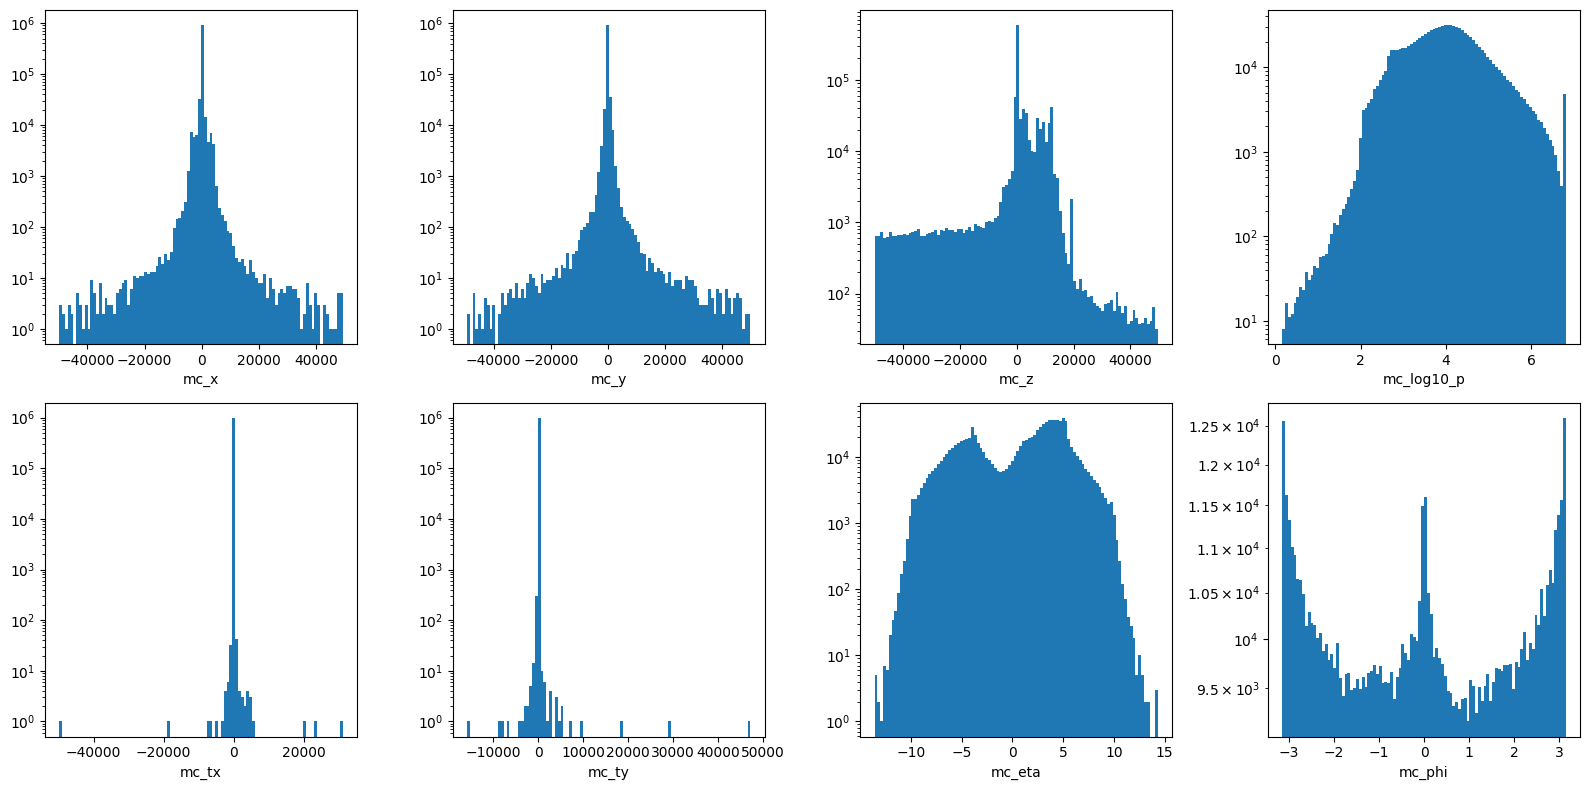

In [9]:
# Performs checks and plots on the first 100k rows
import matplotlib.pyplot as plt

df = sim[acceptance_vars].head(1_000_000, npartitions=10)
plt.figure(figsize=(16,8))
for iVar, var in enumerate(acceptance_vars[:8], 1):
    plt.subplot(2, 4, iVar)
    plt.hist(df[var], bins=100)
    plt.xlabel(var)
    plt.yscale('log')

plt.tight_layout()
plt.show()

### Labels

A loose acceptance cut is applied already at the time of generating the nTuple, still the fraction of particles in acceptance is small.

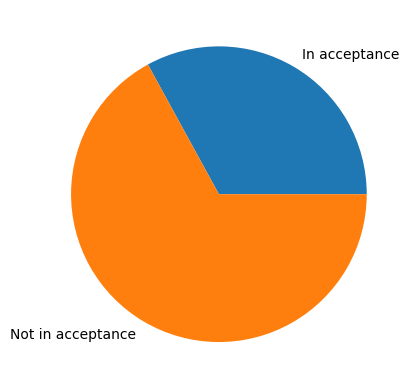

In [10]:
categories = [np.count_nonzero(sim.head(100_000)[label].values) for label in acceptance_labels]
categories.append(100_000 - sum(categories))

plt.pie(categories, labels=["In acceptance", "Not in acceptance"])
plt.show()

## Preprocessing: definintion and training of the `ColumnTransformer`

We define a preprocessing step applying different transformations to different variables.
Indeed, we plan to use the `QuantileTransformer` on continuous features while we should simply ignore the boolean flags such as `is_mu` or `is_h`.

To acheive such a goal we are using `ColumnTransformer` defined in scikit-learn.

We are applying the `QuantileTransformer` to the continuos features while we simply `passthrough` the boolean flags.

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer

X = df.values
n_features = len(acceptance_features)
n_flags = len(acceptance_flags)

preprocessing_step = ColumnTransformer([
    ("quantile", QuantileTransformer(output_distribution='normal'), np.arange(n_features)),
    ("flags", "passthrough", n_features + np.arange(n_flags)) 
])
preprocessing_step = preprocessing_step.fit(X)

Finally we store the trained preprocessing step in the same destination as the model that we are going to train in the next notebook.

In [13]:
from preprocessing_utils import store_as_pickle
display(store_as_pickle(preprocessing_step, "ACCEPTANCE_PREPROCESSING", environ.get("ACCEPTANCE_PREPROCESSING","/workarea/cloud-storage/anderlinil/models/acceptance/tX.pkl")))

2023-03-20 08:40:40.960759: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Train, test and validation

We split the sample in three subset:
 * *train* (50% of the total), used for training
 * *test* (40% of the total), used to assess the quality of the trained model by comparing the distributions obtained from the model with those of the real data
 * *validation* (10% of the toal), used to monitor the training procedure using an independent dataset to assess overtraining
 

### Cache the preprocessed datasets to local storage

Finally, we are ready to process the entire dataset applying the preprocessing step and storing in a local storage the relevant features and labels.

In [14]:
import preprocessing_utils

entries = preprocessing_utils.split_and_store(
    sim[acceptance_vars + acceptance_labels],
    [
        (0.5, environ.get("ACCEPTANCE_TRAIN", "acceptance-train")),
        (0.4, environ.get("ACCEPTANCE_TEST", "acceptance-test")),
        (0.1, environ.get("ACCEPTANCE_VALIDATION", "acceptance-validation"))
    ],
    chunksize=100_000_000,
    features=acceptance_vars,
    labels=acceptance_labels,
    preprocessorX=preprocessing_step
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing acceptance-train
Processing acceptance-test
Processing acceptance-validation


,0
Train,2648127
Test,2117394
Validation,528373


# Reconstruction efficiency

The same steps followed for modelling the acceptance are now to be followed for the model of the reconstruction efficiency of charged particles. 
The model of the efficiency has a significant difference over the acceptance: while a particle is either in acceptance or not, a particle in acceptance can be reconstructed in different ways, or track classes: 
 - long tracks (type: 3) are tracks obtained combining stubs in the vertex locator, in the upstream tracker and in the downstream tracking stations
 - upstream tracks (type: 4) are tracks obtained combining stubs in the vertex locator and in the upstream tracker, but without a matching in the downstream tracking section
 - downstream tracks (type: 5) are tracks obtained combining stubs in the upstream and downstream trackers, but without a matching stub in the vertex locator.
 
Upstream tracks are ususally connected to low momentum particles that were ejected by the magnetic field before reaching the downstream tracker. The resolution on the momentum is rather poor, but the residual magnetic field between the vertex locator and the upstream tracker is sufficient to perform a decent momentum measurement. 

Downstream tracks are mainly due to particles decaying outside the Vertex Locator. Typical examples are the decay products from
 * $K^0_S \to \pi^+ \pi^-$
 * $\Lambda^0 \to p \pi^-$
 
Downstream tracks are crucial for a number of studies involving hyperons.


We define the set of labels accordingly, while for simplicity, the same features as for the acceptance the are used.

In [15]:
sim['recoed_as_long'] = (sim.type==3).astype(np.float32)
sim['recoed_as_upstream'] = (sim.type==4).astype(np.float32)
sim['recoed_as_downstream'] = (sim.type==5).astype(np.float32)
sim['not_recoed'] = (~sim.type.isin([3,4,5])).astype(np.float32)

efficiency_features = acceptance_features
efficiency_flags = acceptance_flags

efficiency_vars = efficiency_features + efficiency_flags
efficiency_labels = ['not_recoed', 'recoed_as_long', 'recoed_as_upstream', 'recoed_as_downstream']

display(HTML ("<H3>Features</H3><UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in efficiency_vars) + "</UL>"))
display(HTML ("<H3>Labels</H3><UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in efficiency_labels) + "</UL>"))

### Cache preprocessed data to local storage

As done for the the preprocessed dataset used to train the acceptance model, we will store in a local folder the datasets ready to be processed with tensorflow.

In [16]:
entries = preprocessing_utils.split_and_store(
    sim[efficiency_vars + efficiency_labels],
    [
        (0.5, environ.get("EFFICIENCY_TRAIN", "efficiency-train")),
        (0.4, environ.get("EFFICIENCY_TEST", "efficiency-test")),
        (0.1, environ.get("EFFICIENCY_VALIDATION", "efficiency-validation"))
    ],
    chunksize=100_000_000,
    features=efficiency_vars,
    labels=efficiency_labels,
    preprocessorX=preprocessing_step
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing efficiency-train
Processing efficiency-test
Processing efficiency-validation


,0
Train,2643092
Test,2121200
Validation,529602


Finally we need to publish the preprocessing step to the same target directory that will host the trained model.

In [17]:
from preprocessing_utils import store_as_pickle
display(store_as_pickle(preprocessing_step, "EFFICIENCY_PREPROCESSING", environ.get("EFFICIENCY_PREPROCESSING","/workarea/cloud-storage/anderlinil/models/efficiency/tX.pkl")))

In [5]:
### export notebooks for comparisons
if environ.get('NB_EXPORT',"False")=="True":
    from os import system,rename
    nb_save  = "/workarea/local/shared/scapelli/notebooks_exports"         # export output dir
    nbs_path = "/workarea/local/shared/scapelli/lb-trksim-train/notebooks" # notebooks folder
    nb_filename = "Preprocessing.ipynb"                                    # notebook name
    extensions  = ["html","pdf"]                                           # export formats
    for ext in extensions:
        system("jupyter nbconvert --log-level=40 --output-dir {0} --to {1} {2}/{3}".format(nb_save,ext.upper(),nbs_path,nb_filename))
    print("Exported {} as {} in {}".format(nb_filename,','.join(extensions),nb_save))

Exported Preprocessing.ipynb as html,pdf in /workarea/local/shared/scapelli/notebooks_exports
